## Exploratory Data Analysis for Climate Change Related Tweets

In [1]:
import os
from tqdm.notebook import tqdm
import gzip
import pandas as pd
import seaborn as sns
import timeit
import json
import matplotlib.pyplot as plt
import numpy as np

## Load Data

In [2]:
DATA_FOLDER = "../suresh2/cctweets_untaxonomy/general/"
DATA_SRC = DATA_FOLDER + "tweet2021presentflattened.json"

# testing the path
data = pd.read_json(DATA_SRC, lines=True, nrows=100)
data.sample(5)

,lang,entities,id,created_at,conversation_id,context_annotations,source,possibly_sensitive,public_metrics,author_id,reply_settings,text,edit_history_tweet_ids,author,__twarc,attachments,geo
54,en,"{'urls': [{'start': 21, 'end': 44, 'url': 'htt...",1588680885444173824,2022-11-04 23:53:34+00:00,1588680885444173824,"[{'domain': {'id': '131', 'name': 'Unified Twi...",Twitter for Android,False,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1511107889804496896,everyone,What climate crisis? https://t.co/5MhLdBhntY,[1588680885444173824],"{'name': 'Pam Causer', 'verified': False, 'pro...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,NaN
33,en,"{'urls': [{'start': 254, 'end': 277, 'url': 'h...",1588681672060731392,2022-11-04 23:56:41+00:00,1588681672060731392,"[{'domain': {'id': '67', 'name': 'Interests an...",Twitter Web App,False,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",1279339968628850688,mentionedUsers,"Thank you, @beckisphere, for your clear explan...",[1588681672060731392],"{'name': 'Jess DePew (He/Him)', 'verified': Fa...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,NaN
11,en,"{'urls': [{'start': 86, 'end': 109, 'url': 'ht...",1588682197237919744,2022-11-04 23:58:46+00:00,1588682197237919744,"[{'domain': {'id': '131', 'name': 'Unified Twi...",Twitter Web App,False,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",992349470,everyone,The Entrepreneurial State Must Lead on Climate...,[1588682197237919744],"{'name': 'John Greene', 'verified': False, 'pr...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,NaN
22,en,"{'urls': [{'start': 88, 'end': 111, 'url': 'ht...",1588681996674691072,2022-11-04 23:57:58+00:00,1588681996674691072,"[{'domain': {'id': '159', 'name': 'States', 'd...",Twitter Web App,False,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1550493181573271552,everyone,North Dakota sees significant drought expansio...,[1588681996674691072],"{'name': 'North Dakota News Cooperative', 'ver...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,NaN
27,en,"{'urls': [{'start': 31, 'end': 54, 'url': 'htt...",1588681868609990656,2022-11-04 23:57:28+00:00,1588681868609990656,"[{'domain': {'id': '159', 'name': 'States', 'd...",Twitter for Android,False,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1576612475973378048,everyone,"Pt1 Mississippi River, DROUGHT https://t.co/VK...",[1588681868609990656],"{'name': 'Pamela Jackson', 'verified': False, ...",{'url': 'https://api.twitter.com/2/tweets/sear...,"{'media_keys': ['7_1588681817082699776'], 'med...",NaN


Let's load the data in its enitirety.

In [3]:
SAMPLE = False
START_ROWS = 6_000_001
MAX_ROWS = 9_000_000 

file_size = os.stat(DATA_SRC).st_size
print(f"File size is {file_size / 2**30:>3,.2f} GB")

nb_rows_read = 0
lines_json = []    

start = timeit.default_timer()

with tqdm(total=file_size, unit='B', unit_scale=True, unit_divisor=1024) as pbar:
    with open(DATA_SRC, "r") as f:
        for line in f:
            # limit the nb of iterations for test purposes
            if (SAMPLE == True) and (nb_rows_read >= MAX_ROWS):
                break
            
            nb_rows_read += 1
            if START_ROWS > nb_rows_read:
                continue
                    
            lines_json.append(json.loads(line))
            if nb_rows_read % 500_000 == 0:
                print(f"{nb_rows_read:,} rows read")

            read_bytes = len(line)
            if read_bytes:
                pbar.set_postfix(file=DATA_SRC[len(DATA_FOLDER):], refresh=False)
                pbar.update(read_bytes)
            
stop = timeit.default_timer()
time_diff = stop - start

print(f"==> total time to read data:        {time_diff/60:>10.0f} min. ({time_diff:.0f}s.)")
print(f"==> number of rows (= videos) read: {nb_rows_read:>10,}")

# create new dataframe with the json lines
data = pd.DataFrame(data=lines_json, index=None)

File size is 40.50 GB


  0%|          | 0.00/40.5G [00:00<?, ?B/s]

6,500,000 rows read
7,000,000 rows read
7,500,000 rows read
8,000,000 rows read
==> total time to read data:                 5 min. (292s.)
==> number of rows (= videos) read:  8,041,921


## Feature extraction and exploration

Let's explore of each of the features indivudally and extract nested features from the existing ones when appropriate.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2041921 entries, 0 to 2041920
Data columns (total 18 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   context_annotations     object
 1   source                  object
 2   id                      object
 3   public_metrics          object
 4   entities                object
 5   conversation_id         object
 6   created_at              object
 7   possibly_sensitive      bool  
 8   lang                    object
 9   author_id               object
 10  reply_settings          object
 11  text                    object
 12  edit_history_tweet_ids  object
 13  author                  object
 14  __twarc                 object
 15  attachments             object
 16  geo                     object
 17  withheld                object
dtypes: bool(1), object(17)
memory usage: 266.8+ MB


We can see that each of the given features has at least one non NaN.So we wish to explore each of them individually.

In [5]:
data.shape

(2041921, 18)

## 1. Feature: lang

In [6]:
lang_groups = data.groupby("lang")['id'].count().reset_index(
  name='Count').sort_values(['Count'], ascending=False)
lang_groups.head(10)

,lang,Count
13,en,1931515
67,zxx,45591
29,ja,9179
19,fr,8918
14,es,6185
60,tl,5690
49,qme,4159
63,und,3715
25,in,3579
21,hi,2700


[]

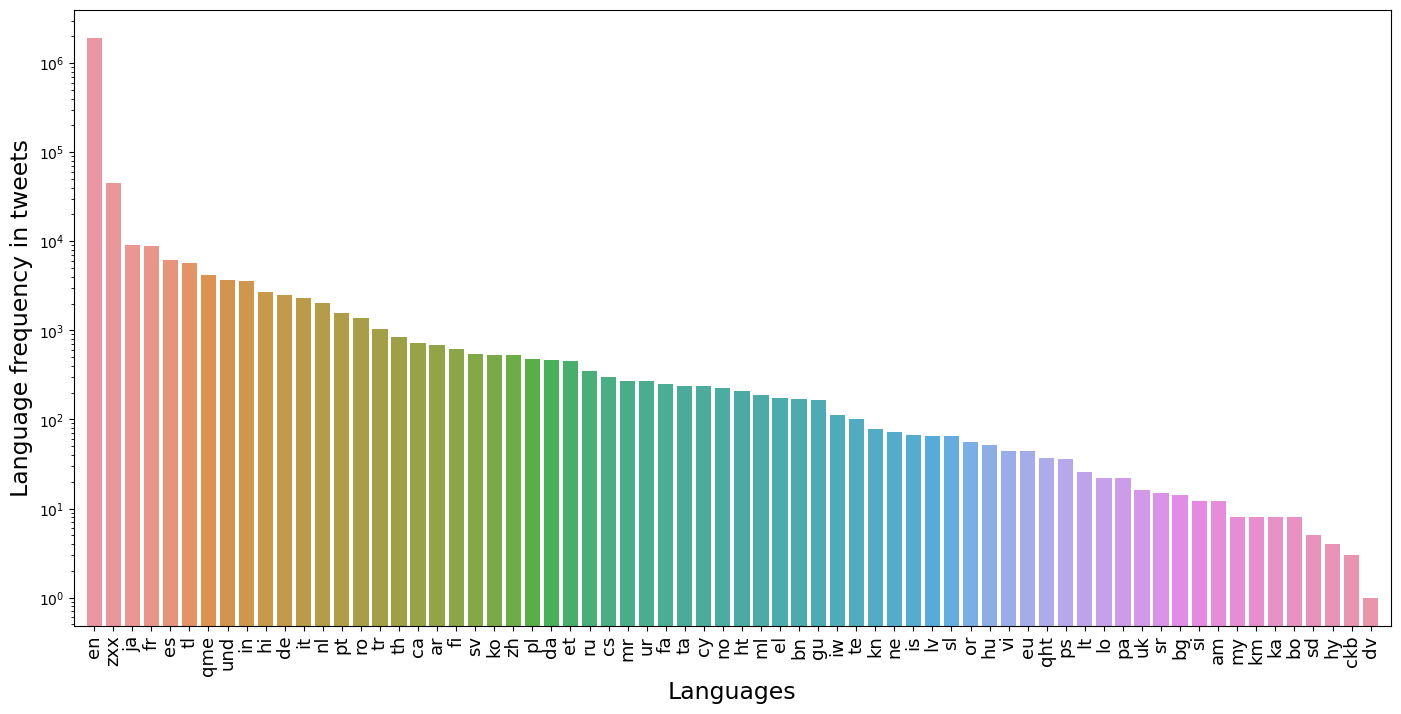

In [7]:
figure = plt.figure(figsize=(17, 8)) 
sns.barplot(data=lang_groups, y="Count", x="lang", orient='v', log=True);
plt.xlabel('Languages', fontsize=17)
plt.ylabel("Language frequency in tweets", fontsize=17)
plt.xticks(rotation=90, fontsize=13)
plt.margins(x=0.01)
plt.plot()

In [8]:
data['lang'].value_counts(normalize=True) * 100

en     94.593033
zxx     2.232750
ja      0.449528
fr      0.436746
es      0.302901
         ...    
bo      0.000392
sd      0.000245
hy      0.000196
ckb     0.000147
dv      0.000049
Name: lang, Length: 68, dtype: float64

English seems to be by far the most frequent of all langauges. It is used in more than 94% of all tweets obtained. It seems that it is okay to drop all the tweets that are not written in English as their number is rather unsignificant, and also it has more limited reach when we look at the size of the audience those tweets are understandable. 

In addtion, we want to keep tweets with the `zxx` langauge code. Those tweets represent mostly tweets with just links to some news articles or images, and thus, it would be intersting for us to explore the reachability of them. 

In [9]:
data[data['lang'] == 'zxx'].sample(3)

,context_annotations,source,id,public_metrics,entities,conversation_id,created_at,possibly_sensitive,lang,author_id,reply_settings,text,edit_history_tweet_ids,author,__twarc,attachments,geo,withheld
908657,NaN,Twitter for Android,1387720080453033986,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'urls': [{'start': 0, 'end': 23, 'url': 'http...",1387720080453033986,2021-04-29T10:47:04.000Z,False,zxx,1293996965307412480,everyone,https://t.co/OX8uMR8cP3,[1387720080453033986],"{'id': '1293996965307412480', 'profile_image_u...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,NaN,NaN
374704,NaN,Twitter Web App,1407759818501337093,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'urls': [{'start': 0, 'end': 23, 'url': 'http...",1407759818501337093,2021-06-23T17:57:50.000Z,False,zxx,483435563,everyone,https://t.co/o8XMoOI7HV,[1407759818501337093],"{'protected': False, 'username': 'SelvarajGuru...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,NaN,NaN
1699554,NaN,Twitter for iPad,1359624685080571907,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'urls': [{'start': 0, 'end': 23, 'url': 'http...",1359624685080571907,2021-02-10T22:06:00.000Z,True,zxx,1079129592084934656,everyone,https://t.co/dxgR4UMI5n,[1359624685080571907],"{'verified': False, 'profile_image_url': 'http...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,NaN,NaN


In [10]:
# filltering tweets in English and zxx code
# data = data[(data['lang'] == 'en') | (data['lang'] == 'zxx')]
# data['lang'].value_counts()

We wish to encode this feature now, if langauge is `en` then we set flag to 1, otherwise 0 (no language).

In [11]:
# data['lang'].replace({'en': 1, 'zxx': 0}, inplace=True)
# data['lang'].value_counts()

## 2. Feature: Entities

In [12]:
entities = pd.json_normalize(data.entities)
entities.head()

,annotations,urls,hashtags,mentions,cashtags
0,"[{'start': 138, 'end': 151, 'probability': 0.8...","[{'start': 153, 'end': 176, 'url': 'https://t....","[{'start': 107, 'end': 121, 'tag': 'ClimateAct...",NaN,NaN
1,"[{'start': 27, 'end': 37, 'probability': 0.776...","[{'start': 42, 'end': 65, 'url': 'https://t.co...","[{'start': 26, 'end': 38, 'tag': 'FossilFuels'}]",NaN,NaN
2,"[{'start': 0, 'end': 11, 'probability': 0.4671...","[{'start': 92, 'end': 115, 'url': 'https://t.c...",NaN,NaN,NaN
3,NaN,"[{'start': 53, 'end': 76, 'url': 'https://t.co...","[{'start': 44, 'end': 51, 'tag': 'actnow'}]",NaN,NaN
4,"[{'start': 73, 'end': 89, 'probability': 0.859...","[{'start': 191, 'end': 214, 'url': 'https://t....","[{'start': 152, 'end': 166, 'tag': 'ClimateCri...","[{'start': 168, 'end': 180, 'username': 'ollie...",NaN


In [13]:
entities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2041921 entries, 0 to 2041920
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   annotations  object
 1   urls         object
 2   hashtags     object
 3   mentions     object
 4   cashtags     object
dtypes: object(5)
memory usage: 77.9+ MB


### Annotations

In [14]:
entities.loc[3, 'annotations']

nan

Annotations in entites could help us indetntify usage of different token types in a tweet. Possible types are:
 1. Person - Barack Obama, Daniel, or George W. Bush

 2. Place - Detroit, Cali, or "San Francisco, California"

 3. Product - Mountain Dew, Mozilla Firefox

 4. Organization - Chicago White Sox, IBM

 5. Other - Diabetes, Super Bowl 50
 
We may want to see if usage of a certain annotation type can be significant for its popularity.

In [15]:
data_size = entities.shape[0]
annotations = {'person_annotations': [0] *  data_size, 'place_annotations': [0] * data_size, 
               'product_annotations': [0] * data_size, 'organization_annotations': [0] * data_size, 
               'other_annotations': [0] * data_size}

for index, entity in entities.iterrows():
    if not isinstance(entity['annotations'], list):
        continue
        
    for annotation in entity['annotations']:
        annotations[annotation['type'].lower() + '_annotations'][index] += 1

annotations = pd.DataFrame(annotations)
annotations.sample(5)

,person_annotations,place_annotations,product_annotations,organization_annotations,other_annotations
140841,0,1,0,0,0
890262,0,0,0,1,0
1091423,0,1,0,0,0
894832,0,3,0,0,0
1936920,3,2,0,0,1


In [16]:
# add annotations to our dataset
data = data.join(annotations)
data.sample(5)

,context_annotations,source,id,public_metrics,entities,conversation_id,created_at,possibly_sensitive,lang,author_id,...,author,__twarc,attachments,geo,withheld,person_annotations,place_annotations,product_annotations,organization_annotations,other_annotations
1414362,"[{'domain': {'id': '131', 'name': 'Unified Twi...",Paper.li,1369423157115912199,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'hashtags': [{'start': 70, 'end': 84, 'tag': ...",1369423157115912199,2021-03-09T23:01:37.000Z,False,en,24477273,...,"{'location': 'US - All over', 'created_at': '2...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,NaN,NaN,0,0,0,0,2
283633,"[{'domain': {'id': '131', 'name': 'Unified Twi...",Twitter Web App,1410447947796561923,"{'retweet_count': 1, 'reply_count': 0, 'like_c...","{'urls': [{'start': 247, 'end': 270, 'url': 'h...",1410447947796561923,2021-07-01T03:59:30.000Z,False,en,1136058927752204288,...,"{'name': 'Citywire South Africa', 'public_metr...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,NaN,NaN,0,0,0,1,0
295284,"[{'domain': {'id': '30', 'name': 'Entities [En...",Hootsuite Inc.,1410214147057491968,"{'retweet_count': 4, 'reply_count': 0, 'like_c...","{'urls': [{'start': 124, 'end': 147, 'url': 'h...",1410214147057491968,2021-06-30T12:30:27.000Z,False,en,21988901,...,"{'verified': True, 'protected': False, 'profil...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,NaN,NaN,0,0,0,0,0
311672,"[{'domain': {'id': '69', 'name': 'News Vertica...",WordPress.com,1409838360034779140,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'annotations': [{'start': 27, 'end': 32, 'pro...",1409838360034779140,2021-06-29T11:37:13.000Z,False,en,1100017331995115520,...,"{'verified': False, 'protected': False, 'profi...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,NaN,NaN,0,1,0,0,0
905196,"[{'domain': {'id': '131', 'name': 'Unified Twi...",Twitter for iPhone,1387806103988285443,"{'retweet_count': 1, 'reply_count': 1, 'like_c...","{'annotations': [{'start': 72, 'end': 79, 'pro...",1387806103988285443,2021-04-29T16:28:54.000Z,False,en,2497235848,...,"{'verified': False, 'protected': False, 'profi...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,NaN,NaN,0,1,0,1,0


### URLs

In [17]:
urls = {'urls_count': [0] * data_size, 'url_image_count': [0] * data_size}
for index, entity in entities.iterrows():
    if not isinstance(entity['urls'], list):
        continue
    
    urls['urls_count'][index] = len(entity['urls']) 
    
    urls_seen = set()
    for url in entity['urls']:
        if url['expanded_url'] in urls_seen:
            continue    
        urls_seen.add(url['expanded_url'])
        
        if 'title' in url and len(url['title']) > 0:
            data.loc[index, 'text'] += f" Title: {url['title']}"
        if 'description' in url and len(url['description']) > 0:
            data.loc[index, 'text'] += f" Desciption: {url['description']}"
        if 'images' in url:
            # twiitter data counts each image twice: one for original and one for formatted
            urls['url_image_count'][index] += len(url['images']) // 2

urls = pd.DataFrame(urls)
urls.sample(5)

,urls_count,url_image_count
552555,1,0
1181775,1,0
966647,1,0
34267,1,0
337204,1,0


In [18]:
# add urls data to our dataset
data = data.join(urls)
data.sample(5)

,context_annotations,source,id,public_metrics,entities,conversation_id,created_at,possibly_sensitive,lang,author_id,...,attachments,geo,withheld,person_annotations,place_annotations,product_annotations,organization_annotations,other_annotations,urls_count,url_image_count
229206,NaN,Twitter Web App,1412045394549395456,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'urls': [{'start': 55, 'end': 78, 'url': 'htt...",1412045394549395456,2021-07-05T13:47:11.000Z,False,en,983964608,...,NaN,NaN,NaN,0,0,0,0,0,1,0
775350,"[{'domain': {'id': '123', 'name': 'Ongoing New...",Twitter Web App,1393288034301276163,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,1393288034301276163,2021-05-14T19:32:08.000Z,False,en,840224402,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1277890,"[{'domain': {'id': '131', 'name': 'Unified Twi...",Twitter Web App,1374942252959551494,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",NaN,1374942252959551494,2021-03-25T04:32:32.000Z,False,en,725525412680355841,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1222413,NaN,Twitter for Android,1377282391241228293,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'annotations': [{'start': 49, 'end': 58, 'pro...",1377282391241228293,2021-03-31T15:31:25.000Z,False,en,1363920287364837376,...,NaN,NaN,NaN,1,0,0,0,0,0,0
184772,NaN,Twitter Web App,1413244477154680840,"{'retweet_count': 1, 'reply_count': 0, 'like_c...","{'hashtags': [{'start': 50, 'end': 56, 'tag': ...",1413244477154680840,2021-07-08T21:11:54.000Z,False,de,1010119326379266048,...,NaN,NaN,NaN,0,0,0,0,0,1,1


### Mentions

In [19]:
mentions = {'mentions_count': [0] * data_size, 'mentions_verifications': [0] * data_size, 
            'mentions_followers': [0] * data_size}

for index, entity in entities.iterrows():
    if not isinstance(entity['mentions'], list):
        continue
    
    mentions['mentions_count'][index] = len(entity['mentions']) 
    for mention in entity['mentions']:
        if 'verified' in mention:
            mentions['mentions_verifications'][index] += mention['verified']
        if 'public_metrics' in mention:
            mentions['mentions_followers'][index] += mention['public_metrics']['followers_count']

mentions = pd.DataFrame(mentions)
mentions.sample(5)

,mentions_count,mentions_verifications,mentions_followers
394862,0,0,0
406623,0,0,0
1905982,2,2,8031957
1238278,0,0,0
1278024,0,0,0


In [20]:
# add mentions to our dataset
data = data.join(mentions)
data.sample(5)

,context_annotations,source,id,public_metrics,entities,conversation_id,created_at,possibly_sensitive,lang,author_id,...,person_annotations,place_annotations,product_annotations,organization_annotations,other_annotations,urls_count,url_image_count,mentions_count,mentions_verifications,mentions_followers
1437392,"[{'domain': {'id': '131', 'name': 'Unified Twi...","Cheap Bots, Done Quick!",1368452266819207171,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'annotations': [{'start': 59, 'end': 63, 'pro...",1368452266819207171,2021-03-07T06:43:39.000Z,False,en,1329492481248014336,...,0,0,0,1,0,0,0,0,0,0
164904,"[{'domain': {'id': '131', 'name': 'Unified Twi...",Twitter for iPhone,1413856855789432832,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'urls': [{'start': 154, 'end': 177, 'url': 'h...",1413856855789432832,2021-07-10T13:45:17.000Z,False,en,191923336,...,0,0,0,0,0,1,0,0,0,0
1927010,"[{'domain': {'id': '10', 'name': 'Person', 'de...",Twitter Web App,1351316644891512834,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'annotations': [{'start': 18, 'end': 22, 'pro...",1351316644891512834,2021-01-18T23:52:49.000Z,False,en,592834521,...,2,2,0,0,0,1,0,0,0,0
493998,"[{'domain': {'id': '131', 'name': 'Unified Twi...",erased17022242,1403638222794760192,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'urls': [{'start': 257, 'end': 280, 'url': 'h...",1403638222794760192,2021-06-12T09:00:05.000Z,False,en,1205602031706288129,...,0,0,0,0,2,1,0,0,0,0
1634444,"[{'domain': {'id': '3', 'name': 'TV Shows', 'd...",Twitter for iPhone,1361865447960936451,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'annotations': [{'start': 140, 'end': 144, 'p...",1361865447960936451,2021-02-17T02:29:59.000Z,False,en,208863928,...,0,1,0,0,0,0,0,0,0,0


### Hashtags and cashtags

In [21]:
tags = {'hashtags': [0] * data_size, 'cashtags': [0] * data_size}
for index, entity in entities.iterrows():
    if isinstance(entity['hashtags'], list):
        tags['hashtags'][index] = len(entity['hashtags'])
    
    if isinstance(entity['cashtags'], list):
        tags['cashtags'][index] = len(entity['cashtags'])

tags = pd.DataFrame(tags)
tags.sample(5)

,hashtags,cashtags
394126,0,0
1663046,2,0
941365,2,0
2031007,0,0
1330157,0,0


In [22]:
# add tags count to our dataset
data = data.join(tags)
data.sample(5)

,context_annotations,source,id,public_metrics,entities,conversation_id,created_at,possibly_sensitive,lang,author_id,...,product_annotations,organization_annotations,other_annotations,urls_count,url_image_count,mentions_count,mentions_verifications,mentions_followers,hashtags,cashtags
2016749,NaN,Twitter for iPhone,1346458497735667713,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'annotations': [{'start': 66, 'end': 67, 'pro...",1346458497735667713,2021-01-05T14:08:16.000Z,False,en,329018957,...,0,0,1,1,0,0,0,0,0,0
4764,"[{'domain': {'id': '123', 'name': 'Ongoing New...",Twitter Web App,1418017285227257856,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'annotations': [{'start': 162, 'end': 165, 'p...",1418017285227257856,2021-07-22T01:17:20.000Z,False,en,127619950,...,0,0,0,4,0,0,0,0,0,0
573680,"[{'domain': {'id': '131', 'name': 'Unified Twi...",WordPress.com,1401135368095686656,"{'retweet_count': 1, 'reply_count': 0, 'like_c...","{'urls': [{'start': 70, 'end': 93, 'url': 'htt...",1401135368095686656,2021-06-05T11:14:38.000Z,False,en,2275375608,...,0,0,0,1,0,0,0,0,0,0
761104,"[{'domain': {'id': '3', 'name': 'TV Shows', 'd...",Twitter for Android,1394130385085157377,"{'retweet_count': 54, 'reply_count': 8, 'like_...","{'urls': [{'start': 278, 'end': 301, 'url': 'h...",1394130385085157377,2021-05-17T03:19:20.000Z,False,en,51391728,...,0,1,0,1,0,0,0,0,3,0
1889202,"[{'domain': {'id': '10', 'name': 'Person', 'de...",Twitter Web App,1352704890829762564,"{'retweet_count': 0, 'reply_count': 0, 'like_c...","{'urls': [{'start': 75, 'end': 98, 'url': 'htt...",1352704890829762564,2021-01-22T19:49:12.000Z,False,en,193374806,...,0,0,0,1,0,1,1,1427925,0,0


Finally, let's drop the entities feature as we don't need it anymore.

In [23]:
data.drop('entities', axis=1, inplace=True)
data.sample(5)

,context_annotations,source,id,public_metrics,conversation_id,created_at,possibly_sensitive,lang,author_id,reply_settings,...,product_annotations,organization_annotations,other_annotations,urls_count,url_image_count,mentions_count,mentions_verifications,mentions_followers,hashtags,cashtags
146871,"[{'domain': {'id': '131', 'name': 'Unified Twi...",histeriusapp,1414551378383544325,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1414551378383544325,2021-07-12T11:45:04.000Z,False,en,236770150,everyone,...,0,0,1,2,1,0,0,0,4,0
1342378,"[{'domain': {'id': '10', 'name': 'Person', 'de...",TweetDeck,1372544660212711428,"{'retweet_count': 3, 'reply_count': 0, 'like_c...",1372544660212711428,2021-03-18T13:45:22.000Z,False,en,321888893,everyone,...,0,0,0,1,0,1,1,18500092,2,0
1063662,"[{'domain': {'id': '131', 'name': 'Unified Twi...",Twitter for iPhone,1383752019056365576,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1383752019056365576,2021-04-18T11:59:24.000Z,False,en,916595222548766720,everyone,...,0,1,0,1,0,0,0,0,0,0
873557,NaN,Twitter Web App,1389301343899242501,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1389301343899242501,2021-05-03T19:30:27.000Z,False,en,322173916,everyone,...,0,0,0,1,0,0,0,0,0,0
1665531,"[{'domain': {'id': '30', 'name': 'Entities [En...",Twitter for Android,1361237974550278144,"{'retweet_count': 10, 'reply_count': 21, 'like...",1361237974550278144,2021-02-15T08:56:38.000Z,False,en,2471055097,everyone,...,0,0,1,1,0,0,0,0,0,0


## 3. Feature: created_at

In [24]:
data[["id", "created_at", "text"]].sample(10)

,id,created_at,text
1422212,1369153173307457540,2021-03-09T05:08:48.000Z,my friend at uni today was handed a flyer by a...
1261550,1375498860752117760,2021-03-26T17:24:18.000Z,Climate change in Romania | DW Documentary htt...
1794638,1356028338473676802,2021-01-31T23:55:24.000Z,Indiana State University Global Warming and We...
1646811,1361676992060395520,2021-02-16T14:01:08.000Z,Join us for a roundtable discussion with @beis...
1575052,1363174893643210754,2021-02-20T17:13:15.000Z,A Republican's damning admission offers a dark...
1450488,1367801013881597952,2021-03-05T11:35:48.000Z,The drought was real so watch this wonwoo tren...
2018024,1346394755714920451,2021-01-05T09:54:59.000Z,"“The facts are clear: the wealthiest 0.54%, ab..."
910580,1387637396829786116,2021-04-29T05:18:31.000Z,Data you need: Green house gases: https://t.co...
897477,1388118880632119297,2021-04-30T13:11:45.000Z,*****THE CLIMATE CHANGE RELIGION*****THE COVID...
338106,1408965192512380928,2021-06-27T01:47:33.000Z,"When I was a kid, a Canadian heat wave was a f..."


In [25]:
data['created_at'].agg(['min', 'max'])

min    2021-01-01T00:00:00.000Z
max    2021-07-22T11:49:04.000Z
Name: created_at, dtype: object

In [26]:
data['created_at'] = pd.to_datetime(data['created_at'])
df_per_month = data.groupby(pd.Grouper(key='created_at', freq='M'))[['id']].count()
df_per_month.index = df_per_month.index.date
df_per_month.head()

,id
2021-01-31,247300
2021-02-28,301156
2021-03-31,275240
2021-04-30,325618
2021-05-31,273560


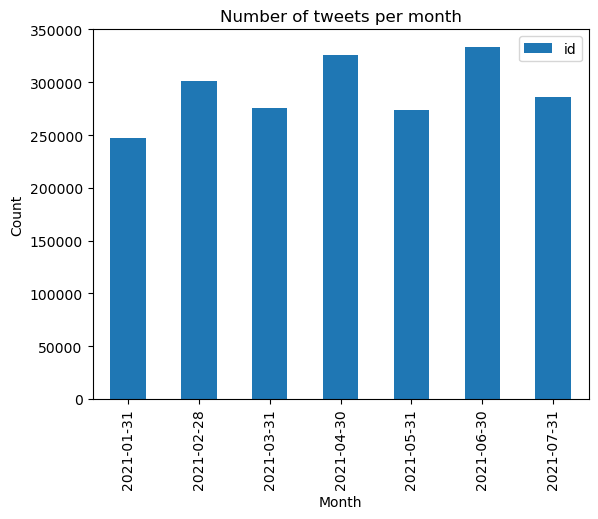

In [27]:
# plot number of tweets per month
df_per_month.plot(kind='bar')
plt.title(f"Number of tweets per month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

## 4. Feature: conversation_id

In [28]:
max(data["conversation_id"].value_counts())

1

We see that more tweets can have the same `conversation_id`. We can freely drop this feature, as it is not very significant for our goal, and we don't have the full conversation available for our data.

In [29]:
data.drop('conversation_id', inplace=True, axis=1)

## 5. Feature: context_annotations

In [30]:
context_annotations = pd.json_normalize(data.context_annotations)
context_annotations.head()

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
0,"{'domain.id': '131', 'domain.name': 'Unified T...","{'domain.id': '131', 'domain.name': 'Unified T...","{'domain.id': '131', 'domain.name': 'Unified T...","{'domain.id': '131', 'domain.name': 'Unified T...",None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,"{'domain.id': '45', 'domain.name': 'Brand Vert...","{'domain.id': '30', 'domain.name': 'Entities [...","{'domain.id': '47', 'domain.name': 'Brand', 'd...","{'domain.id': '47', 'domain.name': 'Brand', 'd...","{'domain.id': '69', 'domain.name': 'News Verti...","{'domain.id': '131', 'domain.name': 'Unified T...","{'domain.id': '131', 'domain.name': 'Unified T...","{'domain.id': '131', 'domain.name': 'Unified T...","{'domain.id': '131', 'domain.name': 'Unified T...",None,...,None,None,None,None,None,None,None,None,None,None
3,"{'domain.id': '131', 'domain.name': 'Unified T...","{'domain.id': '131', 'domain.name': 'Unified T...",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,"{'domain.id': '47', 'domain.name': 'Brand', 'd...","{'domain.id': '131', 'domain.name': 'Unified T...","{'domain.id': '131', 'domain.name': 'Unified T...","{'domain.id': '131', 'domain.name': 'Unified T...","{'domain.id': '131', 'domain.name': 'Unified T...","{'domain.id': '131', 'domain.name': 'Unified T...","{'domain.id': '131', 'domain.name': 'Unified T...","{'domain.id': '131', 'domain.name': 'Unified T...",None,None,...,None,None,None,None,None,None,None,None,None,None


We can use the conntext annotations to faster obtain information about the tweets main topics and contexts. It can help us later idnetifying the topics that seem to have better outreach in the community.

In [31]:
context = {'context': [set() for _ in range(data_size)]}
for index, cntx in context_annotations.iterrows():
    for idx in cntx:
        if idx is None:
            continue
        context['context'][index].add((idx['domain.id'], idx['domain.name']))

context = pd.DataFrame(context)
context.sample(5)

,context
1686143,"{(30, Entities [Entity Service]), (131, Unifie..."
2010144,"{(10, Person), (131, Unified Twitter Taxonomy)..."
1562061,"{(30, Entities [Entity Service]), (131, Unifie..."
1037672,{}
1639064,{}


In [32]:
# add context to our dataset
data = data.join(context)
data.sample(5)

,context_annotations,source,id,public_metrics,created_at,possibly_sensitive,lang,author_id,reply_settings,text,...,organization_annotations,other_annotations,urls_count,url_image_count,mentions_count,mentions_verifications,mentions_followers,hashtags,cashtags,context
789844,NaN,TweetDeck,1392807478333562881,"{'retweet_count': 0, 'reply_count': 3, 'like_c...",2021-05-13 11:42:34+00:00,False,en,17544442,everyone,"In Tarpon Springs, @GovRonDeSantis signed a bi...",...,0,0,1,0,1,1,3089273,0,0,{}
1932102,"[{'domain': {'id': '30', 'name': 'Entities [En...",Twitter Web App,1351082707963551745,"{'retweet_count': 8, 'reply_count': 0, 'like_c...",2021-01-18 08:23:14+00:00,False,en,430709194,everyone,Amazing stat - shows how much oil &amp; gas ex...,...,0,0,2,0,0,0,0,0,0,"{(30, Entities [Entity Service]), (131, Unifie..."
1961854,"[{'domain': {'id': '11', 'name': 'Sport', 'des...",Twidere for Android,1349472595834527745,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2021-01-13 21:45:13+00:00,False,en,2265705620,everyone,Extreme sports in extreme weather:\n\nIn pictu...,...,0,0,2,0,0,0,0,0,0,"{(131, Unified Twitter Taxonomy), (11, Sport)}"
58893,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",Twitter for iPhone,1416647984285167618,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",2021-07-18 06:36:14+00:00,False,en,1093333823608233986,everyone,⚠️ ATTENTION WALMART SHOPPER ⚠️ ERD JUST ADMIT...,...,0,0,1,0,0,0,0,3,0,"{(30, Entities [Entity Service]), (131, Unifie..."
1252061,"[{'domain': {'id': '131', 'name': 'Unified Twi...",Echobox,1375900529856032771,"{'retweet_count': 1, 'reply_count': 1, 'like_c...",2021-03-27 20:00:23+00:00,False,en,514513113,everyone,60 largest banks in the world have invested $3...,...,0,1,1,0,0,0,0,0,0,"{(131, Unified Twitter Taxonomy)}"


In [33]:
# drop context_annotations from the data
data.drop('context_annotations', axis=1, inplace=True)
# for now we decide to also drop context as it is memory expensive and it's not crucial at the moment
data.drop('context', axis=1, inplace=True)

## Feature 6: Source              

In [34]:
data['source'].value_counts()

Twitter Web App        661281
Twitter for iPhone     376095
Twitter for Android    279703
Hootsuite Inc.          75967
TweetDeck               73384
                        ...  
Bama News Now               1
@publicsectorWA             1
eurasia-assembly            1
BillsBibleBasics            1
LCANZ Publish Posts         1
Name: source, Length: 4990, dtype: int64

Over 1100 different source types. Problem there is that categorization is rather problematic. So, we suugest to for the sources that are rarely used put just category other.

We count sources as significant if they have more than 20000 use cases, or at least appear in 1% of tweets.

In [35]:
sum(data["source"].value_counts() > 20000)

13

In [36]:
data["source"].value_counts()[data["source"].value_counts() > 20000].index

Index(['Twitter Web App', 'Twitter for iPhone', 'Twitter for Android',
       'Hootsuite Inc.', 'TweetDeck', 'Twitter for iPad', 'IFTTT', 'dlvr.it',
       'Cheap Bots, Done Quick!', 'Buffer', 'WordPress.com', 'SocialFlow',
       'Sprout Social'],
      dtype='object')

In [37]:
# set all other categories to `Others`
frequent_cats = data["source"].value_counts()[data["source"].value_counts() > 20000].index
data.loc[:, 'source'][[src not in frequent_cats for src in data['source']]] = "Other"
data.sample(10)

/tmp/ipykernel_32687/256596.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'source'][[src not in frequent_cats for src in data['source']]] = "Other"


,source,id,public_metrics,created_at,possibly_sensitive,lang,author_id,reply_settings,text,edit_history_tweet_ids,...,product_annotations,organization_annotations,other_annotations,urls_count,url_image_count,mentions_count,mentions_verifications,mentions_followers,hashtags,cashtags
1069217,WordPress.com,1383489279981088768,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2021-04-17 18:35:22+00:00,False,en,1275076783545573376,everyone,Gift of the Givers reaches out to drought-stri...,[1383489279981088768],...,0,0,0,1,0,0,0,0,0,0
695659,Twitter Web App,1396412515161186307,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2021-05-23 10:27:42+00:00,False,en,464204423,everyone,Climate change disinformation is evolving. So ...,[1396412515161186307],...,0,0,0,1,0,0,0,0,0,0
840512,Twitter Web App,1390528960509923328,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2021-05-07 04:48:33+00:00,False,en,849293340,everyone,Cut methane emissions to rapidly fight climate...,[1390528960509923328],...,0,0,1,1,0,0,0,0,0,0
274969,Twitter Web App,1410645060555784197,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2021-07-01 17:02:45+00:00,False,en,17294271,everyone,"Underpaid firefighters, overstretched budgets:...",[1410645060555784197],...,0,0,0,1,0,0,0,0,0,0
377282,Twitter Web App,1407702000331014148,"{'retweet_count': 3, 'reply_count': 2, 'like_c...",2021-06-23 14:08:05+00:00,False,en,1665595760,everyone,The offshore oil industry is pushing the unsup...,[1407702000331014148],...,0,0,0,1,0,0,0,0,0,0
448115,Twitter for Android,1405253994121990153,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",2021-06-16 20:00:35+00:00,False,zxx,2612668305,everyone,https://t.co/h1rq0WxTWa,[1405253994121990153],...,0,0,0,1,0,0,0,0,0,0
1197484,Other,1378255953645146122,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",2021-04-03 08:00:00+00:00,False,en,98380890,everyone,Drive to Net Zero podcast number 4 is here. \n...,[1378255953645146122],...,0,0,3,2,0,0,0,0,2,0
1996612,dlvr.it,1347590151564783620,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2021-01-08 17:05:03+00:00,False,en,312570061,everyone,"Delta honoured with two ""A"" leadership level r...",[1347590151564783620],...,0,2,0,2,0,0,0,0,0,0
705583,Twitter for iPhone,1395889276571701250,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2021-05-21 23:48:32+00:00,False,en,177047972,everyone,Workers are demanding Scott Morrison take seri...,[1395889276571701250],...,0,0,0,1,1,1,0,2379,0,0
1635029,Twitter for iPhone,1361854876959969285,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2021-02-17 01:47:59+00:00,False,en,2266569698,everyone,You think Texans in government will finally ac...,[1361854876959969285],...,0,0,0,0,0,0,0,0,0,0


## 7. Feature: possibly_sensitive

In [38]:
data['possibly_sensitive'].value_counts()

False    2020130
True       21791
Name: possibly_sensitive, dtype: int64

Let's replace True and False values with the proper integer equivalents of 0 and 1.

In [39]:
data['possibly_sensitive'].replace({True: 1, False: 0}, inplace=True)
data.head()

,source,id,public_metrics,created_at,possibly_sensitive,lang,author_id,reply_settings,text,edit_history_tweet_ids,...,product_annotations,organization_annotations,other_annotations,urls_count,url_image_count,mentions_count,mentions_verifications,mentions_followers,hashtags,cashtags
0,Twitter for Android,1418176262254653442,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2021-07-22 11:49:04+00:00,0,en,1148779294975352832,everyone,The world needs to fast-track commitments to s...,[1418176262254653442],...,0,0,1,1,0,0,0,0,3,0
1,Twitter for iPhone,1418176254361182212,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2021-07-22 11:49:02+00:00,0,en,1620350286,everyone,There are alternatives to #FossilFuels !! http...,[1418176254361182212],...,0,0,1,1,1,0,0,0,1,0
2,Twitter Web App,1418176243288088581,"{'retweet_count': 2, 'reply_count': 1, 'like_c...",2021-07-22 11:48:59+00:00,0,en,19897138,everyone,Amazon Basin is becoming almost neutral in ter...,[1418176243288088581],...,0,1,0,1,0,0,0,0,0,0
3,Twitter for iPhone,1418176242461904903,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2021-07-22 11:48:59+00:00,0,en,1026592240980963328,everyone,Businesses Leaders: Stop the Climate Crisis #a...,[1418176242461904903],...,0,0,0,1,1,0,0,0,1,0
4,Twitter for iPhone,1418176236392796162,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2021-07-22 11:48:57+00:00,0,en,89714083,everyone,Safe haven no more -- record shattering heat w...,[1418176236392796162],...,0,0,0,1,0,2,1,10830243,1,0


## 8. Feature: public_metrics 

In [40]:
public_metrics = pd.json_normalize(data.public_metrics)
public_metrics.head()

,retweet_count,reply_count,like_count,quote_count
0,0,0,1,0
1,0,0,1,0
2,2,1,7,0
3,0,0,0,0
4,0,0,3,0


### Retweet count

In [41]:
public_metrics['retweet_count'].describe()

count    2.041921e+06
mean     4.339249e+00
std      1.357329e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      9.350400e+04
Name: retweet_count, dtype: float64

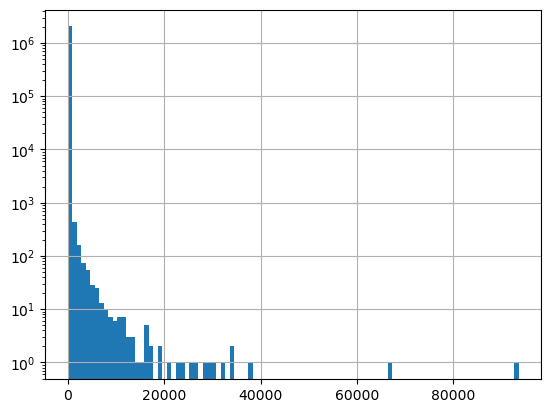

In [42]:
public_metrics['retweet_count'].hist(bins=100, log=True)
plt.show()

Let's add all public metric data to our dataset.

### Reply count

In [43]:
public_metrics['reply_count'].describe()

count    2.041921e+06
mean     1.097936e+00
std      5.035987e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.483200e+04
Name: reply_count, dtype: float64

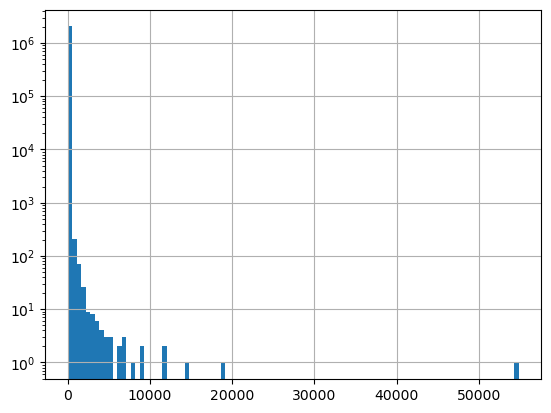

In [44]:
public_metrics['reply_count'].hist(bins=100, log=True)
plt.show()

### Like count

In [45]:
public_metrics['like_count'].describe()

count    2.041921e+06
mean     1.788323e+01
std      8.248241e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.000000e+00
max      4.640700e+05
Name: like_count, dtype: float64

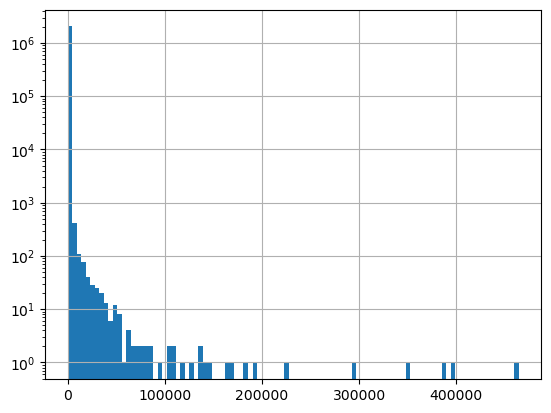

In [46]:
public_metrics['like_count'].hist(bins=100, log=True)
plt.show()

### Quote count

In [47]:
public_metrics['quote_count'].describe()

count    2.041921e+06
mean     4.972445e-01
std      1.752426e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.923000e+03
Name: quote_count, dtype: float64

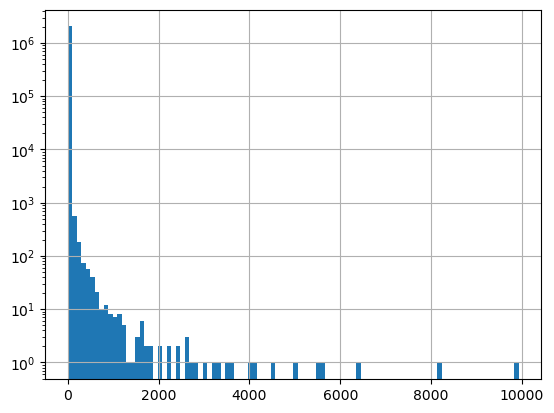

In [48]:
public_metrics['quote_count'].hist(bins=100, log=True)
plt.show()

In [49]:
data = data.join(public_metrics)
data.head()

,source,id,public_metrics,created_at,possibly_sensitive,lang,author_id,reply_settings,text,edit_history_tweet_ids,...,url_image_count,mentions_count,mentions_verifications,mentions_followers,hashtags,cashtags,retweet_count,reply_count,like_count,quote_count
0,Twitter for Android,1418176262254653442,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2021-07-22 11:49:04+00:00,0,en,1148779294975352832,everyone,The world needs to fast-track commitments to s...,[1418176262254653442],...,0,0,0,0,3,0,0,0,1,0
1,Twitter for iPhone,1418176254361182212,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2021-07-22 11:49:02+00:00,0,en,1620350286,everyone,There are alternatives to #FossilFuels !! http...,[1418176254361182212],...,1,0,0,0,1,0,0,0,1,0
2,Twitter Web App,1418176243288088581,"{'retweet_count': 2, 'reply_count': 1, 'like_c...",2021-07-22 11:48:59+00:00,0,en,19897138,everyone,Amazon Basin is becoming almost neutral in ter...,[1418176243288088581],...,0,0,0,0,0,0,2,1,7,0
3,Twitter for iPhone,1418176242461904903,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2021-07-22 11:48:59+00:00,0,en,1026592240980963328,everyone,Businesses Leaders: Stop the Climate Crisis #a...,[1418176242461904903],...,1,0,0,0,1,0,0,0,0,0
4,Twitter for iPhone,1418176236392796162,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2021-07-22 11:48:57+00:00,0,en,89714083,everyone,Safe haven no more -- record shattering heat w...,[1418176236392796162],...,0,2,1,10830243,1,0,0,0,3,0


In [50]:
data.drop("public_metrics", axis=1, inplace=True)

## 9. Features: reply_settings

In [51]:
data['reply_settings'].value_counts()

everyone          2039280
following            1568
mentionedUsers       1038
other                  35
Name: reply_settings, dtype: int64

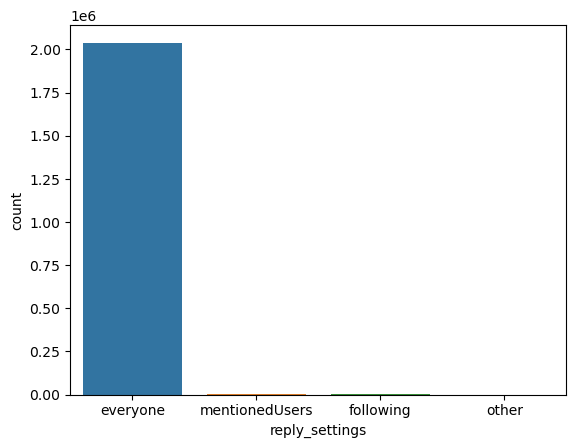

In [52]:
sns.countplot(x=data['reply_settings'])
plt.show()

Replay settings doesn't represent a factor that we should focus for our goal, and in addition it is extremly heavly prevalent towards allowing everyone to reply, so we can drop this feature as not significant.

In [53]:
data.drop('reply_settings', axis=1, inplace=True)
data.head(3)

,source,id,created_at,possibly_sensitive,lang,author_id,text,edit_history_tweet_ids,author,__twarc,...,url_image_count,mentions_count,mentions_verifications,mentions_followers,hashtags,cashtags,retweet_count,reply_count,like_count,quote_count
0,Twitter for Android,1418176262254653442,2021-07-22 11:49:04+00:00,0,en,1148779294975352832,The world needs to fast-track commitments to s...,[1418176262254653442],"{'protected': False, 'pinned_tweet_id': '15329...",{'url': 'https://api.twitter.com/2/tweets/sear...,...,0,0,0,0,3,0,0,0,1,0
1,Twitter for iPhone,1418176254361182212,2021-07-22 11:49:02+00:00,0,en,1620350286,There are alternatives to #FossilFuels !! http...,[1418176254361182212],{'entities': {'description': {'urls': [{'start...,{'url': 'https://api.twitter.com/2/tweets/sear...,...,1,0,0,0,1,0,0,0,1,0
2,Twitter Web App,1418176243288088581,2021-07-22 11:48:59+00:00,0,en,19897138,Amazon Basin is becoming almost neutral in ter...,[1418176243288088581],"{'entities': {'url': {'urls': [{'start': 0, 'e...",{'url': 'https://api.twitter.com/2/tweets/sear...,...,0,0,0,0,0,0,2,1,7,0


## 10. Feature: edit_history_tweet_ids 

Agin, a feature that it is not siginificant to us for our goal. We can simply drop it.

In [54]:
data.drop('edit_history_tweet_ids', axis=1, inplace=True)
data.head(3)

,source,id,created_at,possibly_sensitive,lang,author_id,text,author,__twarc,attachments,...,url_image_count,mentions_count,mentions_verifications,mentions_followers,hashtags,cashtags,retweet_count,reply_count,like_count,quote_count
0,Twitter for Android,1418176262254653442,2021-07-22 11:49:04+00:00,0,en,1148779294975352832,The world needs to fast-track commitments to s...,"{'protected': False, 'pinned_tweet_id': '15329...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,...,0,0,0,0,3,0,0,0,1,0
1,Twitter for iPhone,1418176254361182212,2021-07-22 11:49:02+00:00,0,en,1620350286,There are alternatives to #FossilFuels !! http...,{'entities': {'description': {'urls': [{'start...,{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,...,1,0,0,0,1,0,0,0,1,0
2,Twitter Web App,1418176243288088581,2021-07-22 11:48:59+00:00,0,en,19897138,Amazon Basin is becoming almost neutral in ter...,"{'entities': {'url': {'urls': [{'start': 0, 'e...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,...,0,0,0,0,0,0,2,1,7,0


## 11. Feature: author

In [55]:
author = pd.json_normalize(data.author)
author.head()

,protected,pinned_tweet_id,description,name,username,verified,id,created_at,profile_image_url,public_metrics.followers_count,...,public_metrics.tweet_count,public_metrics.listed_count,location,entities.description.urls,url,entities.url.urls,entities.description.mentions,entities.description.hashtags,withheld.country_codes,entities.description.cashtags
0,False,1532969805439184896,Organic Chemistry👨‍🔬,Tico Guinessha S,guinessha_17,False,1148779294975352832,2019-07-10T02:21:41.000Z,https://pbs.twimg.com/profile_images/153823185...,653,...,1085,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,False,NaN,"TV host , Chispa Florida Director, Mother of 🐉...",Maria Revelles,MariaRRevelles,False,1620350286,2013-07-25T13:31:36.000Z,https://pbs.twimg.com/profile_images/157073183...,292,...,9739,1.0,"Florida, USA","[{'start': 85, 'end': 108, 'url': 'https://t.c...",NaN,NaN,NaN,NaN,NaN,NaN
2,False,1588897278919524357,"Brings you news breaks: Exclusive political, e...",IndiaToday,IndiaToday,True,19897138,2009-02-02T07:21:54.000Z,https://pbs.twimg.com/profile_images/139525367...,6210009,...,1090087,6712.0,India,"[{'start': 97, 'end': 120, 'url': 'https://t.c...",https://t.co/saDvonqrdB,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...",NaN,NaN,NaN,NaN
3,False,NaN,Heyy,Paula,sofiarubiano07,False,1026592240980963328,2018-08-06T22:13:58.000Z,https://pbs.twimg.com/profile_images/150555887...,7,...,145,0.0,"New York, NY",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,False,NaN,"Mostly tweets about climate, clean energy & po...",Ross Macfarlane,ross_macfarlane,False,89714083,2009-11-13T14:50:14.000Z,https://pbs.twimg.com/profile_images/114589714...,3856,...,22129,180.0,Northwest,NaN,NaN,NaN,"[{'start': 67, 'end': 78, 'username': 'SierraC...",NaN,NaN,NaN


In [56]:
author.dropna(how='all', inplace=True, axis=1)
author.head()

,protected,pinned_tweet_id,description,name,username,verified,id,created_at,profile_image_url,public_metrics.followers_count,...,public_metrics.tweet_count,public_metrics.listed_count,location,entities.description.urls,url,entities.url.urls,entities.description.mentions,entities.description.hashtags,withheld.country_codes,entities.description.cashtags
0,False,1532969805439184896,Organic Chemistry👨‍🔬,Tico Guinessha S,guinessha_17,False,1148779294975352832,2019-07-10T02:21:41.000Z,https://pbs.twimg.com/profile_images/153823185...,653,...,1085,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,False,NaN,"TV host , Chispa Florida Director, Mother of 🐉...",Maria Revelles,MariaRRevelles,False,1620350286,2013-07-25T13:31:36.000Z,https://pbs.twimg.com/profile_images/157073183...,292,...,9739,1.0,"Florida, USA","[{'start': 85, 'end': 108, 'url': 'https://t.c...",NaN,NaN,NaN,NaN,NaN,NaN
2,False,1588897278919524357,"Brings you news breaks: Exclusive political, e...",IndiaToday,IndiaToday,True,19897138,2009-02-02T07:21:54.000Z,https://pbs.twimg.com/profile_images/139525367...,6210009,...,1090087,6712.0,India,"[{'start': 97, 'end': 120, 'url': 'https://t.c...",https://t.co/saDvonqrdB,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...",NaN,NaN,NaN,NaN
3,False,NaN,Heyy,Paula,sofiarubiano07,False,1026592240980963328,2018-08-06T22:13:58.000Z,https://pbs.twimg.com/profile_images/150555887...,7,...,145,0.0,"New York, NY",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,False,NaN,"Mostly tweets about climate, clean energy & po...",Ross Macfarlane,ross_macfarlane,False,89714083,2009-11-13T14:50:14.000Z,https://pbs.twimg.com/profile_images/114589714...,3856,...,22129,180.0,Northwest,NaN,NaN,NaN,"[{'start': 67, 'end': 78, 'username': 'SierraC...",NaN,NaN,NaN


In [57]:
author.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2041921 entries, 0 to 2041920
Data columns (total 21 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   protected                       bool   
 1   pinned_tweet_id                 object 
 2   description                     object 
 3   name                            object 
 4   username                        object 
 5   verified                        bool   
 6   id                              object 
 7   created_at                      object 
 8   profile_image_url               object 
 9   public_metrics.followers_count  int64  
 10  public_metrics.following_count  int64  
 11  public_metrics.tweet_count      int64  
 12  public_metrics.listed_count     float64
 13  location                        object 
 14  entities.description.urls       object 
 15  url                             object 
 16  entities.url.urls               object 
 17  entities.description.mentio

Let us drop columns that do not seem significant to us.

In [58]:
author.drop(['created_at', 'location', 
            'pinned_tweet_id', 'id', 'description', 'public_metrics.following_count',
            'public_metrics.tweet_count', 'public_metrics.listed_count', 
            'entities.description.hashtags', 'url', 'entities.url.urls', 'entities.description.urls',
             'entities.description.mentions', 'entities.description.cashtags', 
             'withheld.country_codes'], axis=1, inplace=True)
author.head()

,protected,name,username,verified,profile_image_url,public_metrics.followers_count
0,False,Tico Guinessha S,guinessha_17,False,https://pbs.twimg.com/profile_images/153823185...,653
1,False,Maria Revelles,MariaRRevelles,False,https://pbs.twimg.com/profile_images/157073183...,292
2,False,IndiaToday,IndiaToday,True,https://pbs.twimg.com/profile_images/139525367...,6210009
3,False,Paula,sofiarubiano07,False,https://pbs.twimg.com/profile_images/150555887...,7
4,False,Ross Macfarlane,ross_macfarlane,False,https://pbs.twimg.com/profile_images/114589714...,3856


Let's rename public_metrics.followers_count so its meaning is more clear in our dataset.

In [59]:
author.rename(columns={'public_metrics.followers_count': 'author_followers_count'}, inplace=True)
author.head()

,protected,name,username,verified,profile_image_url,author_followers_count
0,False,Tico Guinessha S,guinessha_17,False,https://pbs.twimg.com/profile_images/153823185...,653
1,False,Maria Revelles,MariaRRevelles,False,https://pbs.twimg.com/profile_images/157073183...,292
2,False,IndiaToday,IndiaToday,True,https://pbs.twimg.com/profile_images/139525367...,6210009
3,False,Paula,sofiarubiano07,False,https://pbs.twimg.com/profile_images/150555887...,7
4,False,Ross Macfarlane,ross_macfarlane,False,https://pbs.twimg.com/profile_images/114589714...,3856


In [60]:
# also let's change True/False values to 0/1
author['verified'].replace({True: 1, False: 0}, inplace=True)
author['protected'].replace({True: 1, False: 0}, inplace=True)
author.head()

,protected,name,username,verified,profile_image_url,author_followers_count
0,0,Tico Guinessha S,guinessha_17,0,https://pbs.twimg.com/profile_images/153823185...,653
1,0,Maria Revelles,MariaRRevelles,0,https://pbs.twimg.com/profile_images/157073183...,292
2,0,IndiaToday,IndiaToday,1,https://pbs.twimg.com/profile_images/139525367...,6210009
3,0,Paula,sofiarubiano07,0,https://pbs.twimg.com/profile_images/150555887...,7
4,0,Ross Macfarlane,ross_macfarlane,0,https://pbs.twimg.com/profile_images/114589714...,3856


In [61]:
# set flag feature for profila image, exits is set to 1, otherwise 0
author.loc[:, "profile_image_url"][~author['profile_image_url'].isnull()] = 1
author.loc[:, "profile_image_url"][author['profile_image_url'].isnull()] = 0
author.head()

/tmp/ipykernel_32687/1815783450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author.loc[:, "profile_image_url"][~author['profile_image_url'].isnull()] = 1
/tmp/ipykernel_32687/1815783450.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author.loc[:, "profile_image_url"][author['profile_image_url'].isnull()] = 0


,protected,name,username,verified,profile_image_url,author_followers_count
0,0,Tico Guinessha S,guinessha_17,0,1,653
1,0,Maria Revelles,MariaRRevelles,0,1,292
2,0,IndiaToday,IndiaToday,1,1,6210009
3,0,Paula,sofiarubiano07,0,1,7
4,0,Ross Macfarlane,ross_macfarlane,0,1,3856


In [62]:
# let's put together name and username as they appear on the author's tweet
author.loc[:, 'name'] += ' @' + author['username'] 
author.head()

,protected,name,username,verified,profile_image_url,author_followers_count
0,0,Tico Guinessha S @guinessha_17,guinessha_17,0,1,653
1,0,Maria Revelles @MariaRRevelles,MariaRRevelles,0,1,292
2,0,IndiaToday @IndiaToday,IndiaToday,1,1,6210009
3,0,Paula @sofiarubiano07,sofiarubiano07,0,1,7
4,0,Ross Macfarlane @ross_macfarlane,ross_macfarlane,0,1,3856


In [63]:
# we can drop now the username column
# and also let's rename the name colum to be more clear
author.drop('username', axis=1, inplace=True)
author.rename(columns={'name': 'author_name'}, inplace=True)
author.head()

,protected,author_name,verified,profile_image_url,author_followers_count
0,0,Tico Guinessha S @guinessha_17,0,1,653
1,0,Maria Revelles @MariaRRevelles,0,1,292
2,0,IndiaToday @IndiaToday,1,1,6210009
3,0,Paula @sofiarubiano07,0,1,7
4,0,Ross Macfarlane @ross_macfarlane,0,1,3856


In [64]:
author['author_followers_count'].describe()

count    2.041921e+06
mean     1.048477e+05
std      1.368386e+06
min     -1.000000e+00
25%      2.450000e+02
50%      1.179000e+03
75%      5.298000e+03
max      1.333593e+08
Name: author_followers_count, dtype: float64

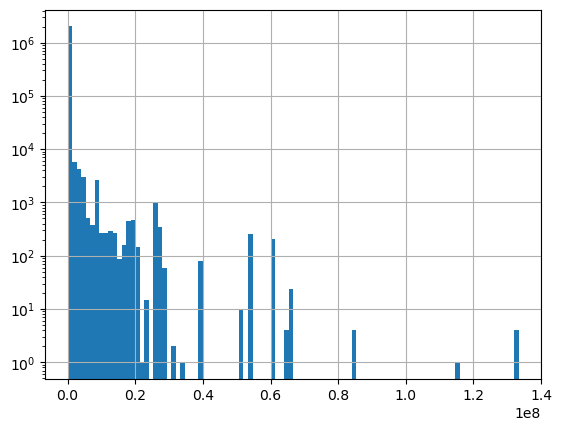

In [65]:
author['author_followers_count'].hist(bins=100, log=True);

In [66]:
# add author to our dataset
data = data.join(author)
data.head()

,source,id,created_at,possibly_sensitive,lang,author_id,text,author,__twarc,attachments,...,cashtags,retweet_count,reply_count,like_count,quote_count,protected,author_name,verified,profile_image_url,author_followers_count
0,Twitter for Android,1418176262254653442,2021-07-22 11:49:04+00:00,0,en,1148779294975352832,The world needs to fast-track commitments to s...,"{'protected': False, 'pinned_tweet_id': '15329...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,...,0,0,0,1,0,0,Tico Guinessha S @guinessha_17,0,1,653
1,Twitter for iPhone,1418176254361182212,2021-07-22 11:49:02+00:00,0,en,1620350286,There are alternatives to #FossilFuels !! http...,{'entities': {'description': {'urls': [{'start...,{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,...,0,0,0,1,0,0,Maria Revelles @MariaRRevelles,0,1,292
2,Twitter Web App,1418176243288088581,2021-07-22 11:48:59+00:00,0,en,19897138,Amazon Basin is becoming almost neutral in ter...,"{'entities': {'url': {'urls': [{'start': 0, 'e...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,...,0,2,1,7,0,0,IndiaToday @IndiaToday,1,1,6210009
3,Twitter for iPhone,1418176242461904903,2021-07-22 11:48:59+00:00,0,en,1026592240980963328,Businesses Leaders: Stop the Climate Crisis #a...,"{'protected': False, 'description': 'Heyy', 'n...",{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,...,0,0,0,0,0,0,Paula @sofiarubiano07,0,1,7
4,Twitter for iPhone,1418176236392796162,2021-07-22 11:48:57+00:00,0,en,89714083,Safe haven no more -- record shattering heat w...,{'entities': {'description': {'mentions': [{'s...,{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,...,0,0,0,3,0,0,Ross Macfarlane @ross_macfarlane,0,1,3856


In [67]:
data.drop("author", axis=1, inplace=True)

## 12. Feature: attachments

In [68]:
data['attachments'][~data['attachments'].isnull()].head()

10    {'media_keys': ['3_1418176115399487489'], 'med...
11    {'media_keys': ['3_1418176082235232257'], 'med...
17    {'media_keys': ['7_1418175847538728960'], 'med...
20    {'media_keys': ['3_1418172592804925447'], 'med...
22    {'media_keys': ['3_1418175758929780741'], 'med...
Name: attachments, dtype: object

In [69]:
attachements = data['attachments'][~data['attachments'].isnull()]
attachements.head()

10    {'media_keys': ['3_1418176115399487489'], 'med...
11    {'media_keys': ['3_1418176082235232257'], 'med...
17    {'media_keys': ['7_1418175847538728960'], 'med...
20    {'media_keys': ['3_1418172592804925447'], 'med...
22    {'media_keys': ['3_1418175758929780741'], 'med...
Name: attachments, dtype: object

In [70]:
#attachements.loc[0]

In [71]:
types = set()
for attachement in attachements:
    if 'media' in attachement:
        for med in attachement['media']:
            types.add(med['type'])

types

{'animated_gif', 'photo', 'video'}

There are 3 types of attachemnts here.

In [72]:
attach = {key + '_count': [0] * data_size for key in types}
for label, attachement in attachements.items():
    if 'media' in attachement:
        for med in attachement['media']:
            attach[med['type'] + '_count'][label] += 1
            
attach = pd.DataFrame(attach)
attach.sample(5)

,photo_count,animated_gif_count,video_count
603060,0,0,0
1005234,0,0,0
1468604,2,0,0
956114,0,0,0
482464,0,0,0


In [73]:
# add author to our dataset
data = data.join(attach)
data.head()

,source,id,created_at,possibly_sensitive,lang,author_id,text,__twarc,attachments,geo,...,like_count,quote_count,protected,author_name,verified,profile_image_url,author_followers_count,photo_count,animated_gif_count,video_count
0,Twitter for Android,1418176262254653442,2021-07-22 11:49:04+00:00,0,en,1148779294975352832,The world needs to fast-track commitments to s...,{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,NaN,...,1,0,0,Tico Guinessha S @guinessha_17,0,1,653,0,0,0
1,Twitter for iPhone,1418176254361182212,2021-07-22 11:49:02+00:00,0,en,1620350286,There are alternatives to #FossilFuels !! http...,{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,NaN,...,1,0,0,Maria Revelles @MariaRRevelles,0,1,292,0,0,0
2,Twitter Web App,1418176243288088581,2021-07-22 11:48:59+00:00,0,en,19897138,Amazon Basin is becoming almost neutral in ter...,{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,NaN,...,7,0,0,IndiaToday @IndiaToday,1,1,6210009,0,0,0
3,Twitter for iPhone,1418176242461904903,2021-07-22 11:48:59+00:00,0,en,1026592240980963328,Businesses Leaders: Stop the Climate Crisis #a...,{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,NaN,...,0,0,0,Paula @sofiarubiano07,0,1,7,0,0,0
4,Twitter for iPhone,1418176236392796162,2021-07-22 11:48:57+00:00,0,en,89714083,Safe haven no more -- record shattering heat w...,{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,NaN,...,3,0,0,Ross Macfarlane @ross_macfarlane,0,1,3856,0,0,0


In [74]:
data.drop("attachments", inplace=True, axis=1)

## 13. Features geo, __twarc, withheld

In [75]:
data['geo'][~data['geo'].isnull()].head()

84     {'place_id': '07d9d24b74487001', 'country': 'V...
87     {'place_id': '1010ecfa7d3a40f8', 'country': 'V...
149    {'place_id': '4c9617680dec8914', 'country': 'V...
151    {'place_id': '01864a8a64df9dc4', 'country': 'A...
270    {'place_id': 'c3f37afa9efcf94b', 'geo': {'type...
Name: geo, dtype: object

In [76]:
data.loc[39, 'geo']

nan

Represents just georaphic location from where tweet is sent. Many values are NaN, and feature is not very significant for our goal, we can drop it.

In [77]:
data.drop('geo', inplace=True, axis=1)
data.head()

,source,id,created_at,possibly_sensitive,lang,author_id,text,__twarc,withheld,person_annotations,...,like_count,quote_count,protected,author_name,verified,profile_image_url,author_followers_count,photo_count,animated_gif_count,video_count
0,Twitter for Android,1418176262254653442,2021-07-22 11:49:04+00:00,0,en,1148779294975352832,The world needs to fast-track commitments to s...,{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,0,...,1,0,0,Tico Guinessha S @guinessha_17,0,1,653,0,0,0
1,Twitter for iPhone,1418176254361182212,2021-07-22 11:49:02+00:00,0,en,1620350286,There are alternatives to #FossilFuels !! http...,{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,0,...,1,0,0,Maria Revelles @MariaRRevelles,0,1,292,0,0,0
2,Twitter Web App,1418176243288088581,2021-07-22 11:48:59+00:00,0,en,19897138,Amazon Basin is becoming almost neutral in ter...,{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,0,...,7,0,0,IndiaToday @IndiaToday,1,1,6210009,0,0,0
3,Twitter for iPhone,1418176242461904903,2021-07-22 11:48:59+00:00,0,en,1026592240980963328,Businesses Leaders: Stop the Climate Crisis #a...,{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,0,...,0,0,0,Paula @sofiarubiano07,0,1,7,0,0,0
4,Twitter for iPhone,1418176236392796162,2021-07-22 11:48:57+00:00,0,en,89714083,Safe haven no more -- record shattering heat w...,{'url': 'https://api.twitter.com/2/tweets/sear...,NaN,0,...,3,0,0,Ross Macfarlane @ross_macfarlane,0,1,3856,0,0,0


In [78]:
# again feature not very useful for us
data.drop('__twarc', inplace=True, axis=1)
data.head()

,source,id,created_at,possibly_sensitive,lang,author_id,text,withheld,person_annotations,place_annotations,...,like_count,quote_count,protected,author_name,verified,profile_image_url,author_followers_count,photo_count,animated_gif_count,video_count
0,Twitter for Android,1418176262254653442,2021-07-22 11:49:04+00:00,0,en,1148779294975352832,The world needs to fast-track commitments to s...,NaN,0,0,...,1,0,0,Tico Guinessha S @guinessha_17,0,1,653,0,0,0
1,Twitter for iPhone,1418176254361182212,2021-07-22 11:49:02+00:00,0,en,1620350286,There are alternatives to #FossilFuels !! http...,NaN,0,0,...,1,0,0,Maria Revelles @MariaRRevelles,0,1,292,0,0,0
2,Twitter Web App,1418176243288088581,2021-07-22 11:48:59+00:00,0,en,19897138,Amazon Basin is becoming almost neutral in ter...,NaN,0,0,...,7,0,0,IndiaToday @IndiaToday,1,1,6210009,0,0,0
3,Twitter for iPhone,1418176242461904903,2021-07-22 11:48:59+00:00,0,en,1026592240980963328,Businesses Leaders: Stop the Climate Crisis #a...,NaN,0,0,...,0,0,0,Paula @sofiarubiano07,0,1,7,0,0,0
4,Twitter for iPhone,1418176236392796162,2021-07-22 11:48:57+00:00,0,en,89714083,Safe haven no more -- record shattering heat w...,NaN,0,1,...,3,0,0,Ross Macfarlane @ross_macfarlane,0,1,3856,0,0,0


In [79]:
data['withheld'][~data['withheld'].isnull()]

2395           {'copyright': False, 'country_codes': ['IN']}
2432           {'copyright': False, 'country_codes': ['TR']}
4148       {'copyright': False, 'country_codes': ['AT', '...
4357           {'copyright': False, 'country_codes': ['IN']}
7209           {'copyright': False, 'country_codes': ['IN']}
                                 ...                        
2034894        {'copyright': False, 'country_codes': ['IN']}
2035023        {'copyright': False, 'country_codes': ['IN']}
2035056        {'copyright': False, 'country_codes': ['IN']}
2035588        {'copyright': False, 'country_codes': ['IN']}
2035591        {'copyright': False, 'country_codes': ['IN']}
Name: withheld, Length: 592, dtype: object

In [80]:
data.loc[6446, 'withheld']

nan

Again, feature with almost non NaN values. Not too useful, we can drop it.

In [81]:
# again feature not very useful for us
data.drop('withheld', inplace=True, axis=1)
data.head()

,source,id,created_at,possibly_sensitive,lang,author_id,text,person_annotations,place_annotations,product_annotations,...,like_count,quote_count,protected,author_name,verified,profile_image_url,author_followers_count,photo_count,animated_gif_count,video_count
0,Twitter for Android,1418176262254653442,2021-07-22 11:49:04+00:00,0,en,1148779294975352832,The world needs to fast-track commitments to s...,0,0,0,...,1,0,0,Tico Guinessha S @guinessha_17,0,1,653,0,0,0
1,Twitter for iPhone,1418176254361182212,2021-07-22 11:49:02+00:00,0,en,1620350286,There are alternatives to #FossilFuels !! http...,0,0,0,...,1,0,0,Maria Revelles @MariaRRevelles,0,1,292,0,0,0
2,Twitter Web App,1418176243288088581,2021-07-22 11:48:59+00:00,0,en,19897138,Amazon Basin is becoming almost neutral in ter...,0,0,0,...,7,0,0,IndiaToday @IndiaToday,1,1,6210009,0,0,0
3,Twitter for iPhone,1418176242461904903,2021-07-22 11:48:59+00:00,0,en,1026592240980963328,Businesses Leaders: Stop the Climate Crisis #a...,0,0,0,...,0,0,0,Paula @sofiarubiano07,0,1,7,0,0,0
4,Twitter for iPhone,1418176236392796162,2021-07-22 11:48:57+00:00,0,en,89714083,Safe haven no more -- record shattering heat w...,0,1,0,...,3,0,0,Ross Macfarlane @ross_macfarlane,0,1,3856,0,0,0


Let's only keep English tweets as tweets of interest. In any case, they reresent the huge majority of all present tweets. After that, we are free to trop language column.

In [82]:
# filltering tweets in English
data = data[data['lang'] == 'en']
data.drop('lang', axis=1, inplace=True)
data.sample(5)

,source,id,created_at,possibly_sensitive,author_id,text,person_annotations,place_annotations,product_annotations,organization_annotations,...,like_count,quote_count,protected,author_name,verified,profile_image_url,author_followers_count,photo_count,animated_gif_count,video_count
670892,Other,1397311537971273729,2021-05-25 22:00:06+00:00,0,761756733731516417,Dutch court to rule on Shell's climate change ...,0,0,0,1,...,0,0,0,ZAQS World News @ZAQSNews,0,1,845,0,0,0
1080340,WordPress.com,1383008727473606657,2021-04-16 10:45:50+00:00,0,975783397967777792,AFRICA: IFAD and IsDB finance climate change a...,0,1,0,2,...,0,0,0,Afrik21 @afrik21,0,1,1504,0,0,0
1664752,Twitter for Android,1361268117788262402,2021-02-15 10:56:25+00:00,0,137373770,*Effect Of Climate Change!!!* https://t.co/NKN...,0,0,0,0,...,0,0,0,brij @brij_m,0,1,10,1,0,0
250990,Twitter Web App,1411293535073193985,2021-07-03 11:59:33+00:00,0,918990291495018498,Mexico water supply buckles on worsening droug...,0,1,0,0,...,0,0,0,Margaret Reis @margreis9,0,1,3000,0,0,0
64996,Twitter for Android,1416454117485076483,2021-07-17 17:45:52+00:00,0,3495805883,Some bang global warming,0,0,0,0,...,1,0,0,Bill Farrell @Billopad209,0,1,789,0,0,0


Like, retweet, reply - for the metric of succuessfulness!

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1931515 entries, 0 to 2041920
Data columns (total 30 columns):
 #   Column                    Dtype              
---  ------                    -----              
 0   source                    object             
 1   id                        object             
 2   created_at                datetime64[ns, UTC]
 3   possibly_sensitive        int64              
 4   author_id                 object             
 5   text                      object             
 6   person_annotations        int64              
 7   place_annotations         int64              
 8   product_annotations       int64              
 9   organization_annotations  int64              
 10  other_annotations         int64              
 11  urls_count                int64              
 12  url_image_count           int64              
 13  mentions_count            int64              
 14  mentions_verifications    int64              
 15  mentions_follow

In [84]:
data.to_json("tweets-4.json")